# ENEM 2016

Agora devemos prever se o candidato é treineiro ou não.

## Setup

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sct
import math

import matplotlib.pyplot as plt
import seaborn as sns

from orderedset import OrderedSet

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

try:
    sklearn.set_config(display='diagram')
except:
    pass

## Carregando as bases de treino e teste

In [4]:
df_train = pd.read_csv('train.csv', index_col=0)
df_train.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,...,5.0,A,A,A,A,A,A,A,B,D
2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,...,NaN,A,A,C,A,B,A,A,C,A
3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,...,NaN,A,A,A,A,C,A,A,B,A
4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,...,5.0,C,A,A,A,A,D,A,A,A
5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,...,NaN,A,A,A,A,A,A,A,A,A


In [5]:
df_test = pd.read_csv('test.csv')
df_test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,...,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,...,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,...,40.0,480.0,E,E,E,C,B,B,C,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,...,80.0,720.0,E,E,E,B,B,B,D,A


## EDA / Feature Engineering

### Análises iniciais

In [6]:
df_train.shape

(13730, 166)

In [7]:
df_test.shape

(4570, 43)

In [8]:
common_cols = list(OrderedSet(df_train.columns) & OrderedSet(df_test.columns))
common_cols

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

In [9]:
def train_test_summary(train, test):
    """
    Traz algumas informações interessantes das bases de treino e teste
    
    :param train: pd.DataFrame de treino
    :param test: pd.DataFrame de teste
    :returns: pd.DataFrame contendo as informações comparativas
    """
    return pd.DataFrame({
        'dtype': train.dtypes,
        'train nulls': train.isna().sum(),
        'train nulls (%)': train.isna().mean(),
        'train nunique': train.nunique(),
        'test nulls': test.isna().sum(),
        'test nulls (%)': test.isna().mean(),
        'test nunique': test.nunique()
    })

train_test_summary(df_train[common_cols + ['IN_TREINEIRO']], df_test[common_cols])

,dtype,train nulls,train nulls (%),train nunique,test nulls,test nulls (%),test nunique
CO_UF_RESIDENCIA,int64,0,0.000000,27,0.0,0.000000,27.0
IN_BAIXA_VISAO,int64,0,0.000000,2,0.0,0.000000,2.0
IN_CEGUEIRA,int64,0,0.000000,1,0.0,0.000000,2.0
IN_DISCALCULIA,int64,0,0.000000,2,0.0,0.000000,1.0
IN_DISLEXIA,int64,0,0.000000,2,0.0,0.000000,2.0
IN_GESTANTE,int64,0,0.000000,2,0.0,0.000000,2.0
IN_IDOSO,int64,0,0.000000,2,0.0,0.000000,2.0
IN_SABATISTA,int64,0,0.000000,2,0.0,0.000000,2.0
IN_SURDEZ,int64,0,0.000000,2,0.0,0.000000,1.0
IN_TREINEIRO,int64,0,0.000000,2,NaN,NaN,NaN


Antes de droparmos algumas features ou por ter um único valor ou por ter dados nulos em excesso, vamos criar uma feature para identificar se a pessoa tem alguma deficiência ou não. Isso pode nos ajudar em alguma coisa.

In [10]:
df_train['IN_PCD'] = np.int64(df_train.IN_BAIXA_VISAO | 
                              df_train.IN_CEGUEIRA | 
                              df_train.IN_SURDEZ |
                              df_train.IN_DEFICIENCIA_AUDITIVA |
                              df_train.IN_SURDO_CEGUEIRA |
                              df_train.IN_DEFICIENCIA_FISICA |
                              df_train.IN_DEFICIENCIA_MENTAL |
                              df_train.IN_DEFICIT_ATENCAO |
                              df_train.IN_DISLEXIA |
                              df_train.IN_DISCALCULIA |
                              df_train.IN_AUTISMO |
                              df_train.IN_VISAO_MONOCULAR | 
                              df_train.IN_OUTRA_DEF)

df_test['IN_PCD'] = np.int64(df_test.IN_BAIXA_VISAO | 
                             df_test.IN_CEGUEIRA | 
                             df_test.IN_SURDEZ |
                             df_test.IN_DISLEXIA |
                             df_test.IN_DISCALCULIA)

common_cols.append('IN_PCD')

Beleza, agora vamos definir nosso target e guardar somente as colunas em comum.

In [11]:
target_col = 'IN_TREINEIRO'

df_train = df_train[common_cols + [target_col]]
# garantindo a mesma ordem das colunas
df_test = df_test[common_cols]

In [12]:
# juntando os 2 facilita a criação de novas features
data = pd.concat([df_train, df_test], keys=['train', 'test'], sort=False)
data.head()

NU_INSCRICAO  CO_UF_RESIDENCIA  \
train 1  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad                43   
      2  2c3acac4b33ec2b195d77e7c04a2d75727fad723                23   
      3  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568                23   
      4  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe                33   
      5  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268                13   

        SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  \
train 1               RS        24       M            1                 1   
      2               CE        17       F            3                 1   
      3               CE        21       F            3                 1   
      4               RJ        25       F            0                 1   
      5               AM        28       M            2                 1   

         TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  ...  Q001  Q002  Q006  \
train 1                1                4          1  ...     D     D     C   
      2                2                0          2  ...     A     A     B   
      3                3                0          1  ...     D     D     C   
      4                1                9          1  ...     H     E     E   
      5                1                4          1  ...     E     D     C   

         Q024  Q025  Q026  Q027  Q047  IN_PCD  IN_TREINEIRO  
train 1     A     A     C     H     A       0           0.0  
      2     A     A     A   NaN     A       0           0.0  
      3     A     A     A   NaN     A       0           0.0  
      4     C     B     C     F     D       0           0.0  
      5     A     A     B     F     A       0           0.0  

[5 rows x 45 columns]

Agora sim vamos dar um drop em algumas features.

In [13]:
cols_to_drop = [
    'Q027',                   # muitos dados nulos
    'TP_DEPENDENCIA_ADM_ESC', # muitos dados nulos
    'TP_ENSINO',              # muitos dados nulos
    'SG_UF_RESIDENCIA',       # já existe uma coluna codificada dela
    'IN_BAIXA_VISAO',         # já condensamos na IN_PCD
    'IN_CEGUEIRA',            # já condensamos na IN_PCD
    'IN_SURDEZ',              # já condensamos na IN_PCD
    'IN_DISLEXIA',            # já condensamos na IN_PCD
    'IN_DISCALCULIA'          # já condensamos na IN_PCD
]

data.drop(columns=cols_to_drop, inplace=True)

### Análise dos dados nulos

In [14]:
def nullity_heatmap(dataframe):
    """
    Plota heatmap de correlação dos dados nulos.
    
    :param dataframe: pd.DataFrame com os dados para serem correlacionados.
    """
    corr = dataframe.isna().corr()
    cols = corr.columns[corr.count()>0]
    corr = corr.loc[cols, cols]
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, cmap='RdBu', annot=True, vmin=-1, vmax=1, fmt='.2f')

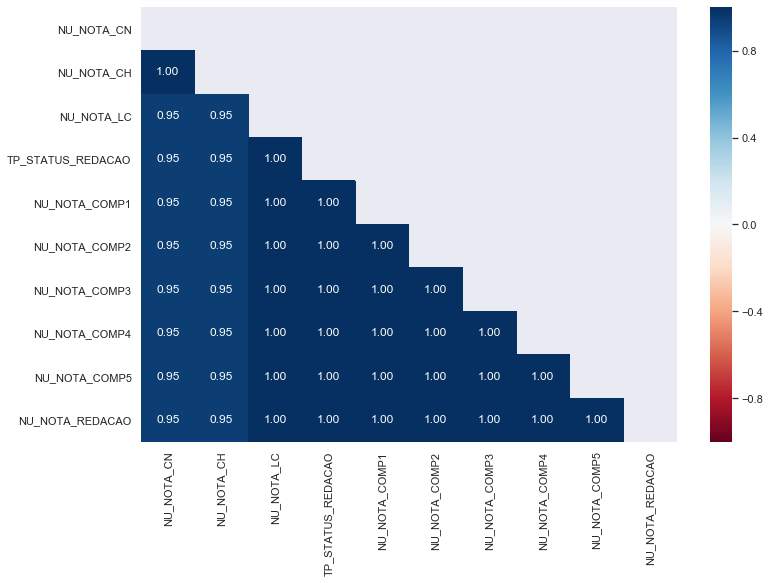

In [15]:
nullity_heatmap(data.xs('train'))

Bem, como vimos na semana passada, os dados nulos tem forte relação com outras features, pois estão relacionadas à eliminação do candidato nas provas. Muitas eliminações se dão ao fato do candidato nem ir fazer a prova.

### Tratando dados nulos

In [16]:
cols_to_fix = [
    'NU_NOTA_CH', 
    'NU_NOTA_CN',
    'NU_NOTA_LC',
    'NU_NOTA_COMP1', 
    'NU_NOTA_COMP2', 
    'NU_NOTA_COMP3', 
    'NU_NOTA_COMP4', 
    'NU_NOTA_COMP5',
    'NU_NOTA_REDACAO'
]

for col in cols_to_fix:
    data[col] = data[col].fillna(0.)

In [17]:
cols_to_fix = [
    'TP_STATUS_REDACAO'
]

for col in cols_to_fix:
    data[col] = data[col].fillna(0.).astype(int)

### Codificando features categóricas

Vamos codificar com `OrdinalEncoder` as features categóricas que possuem texto.

In [18]:
cols_to_encode = [
    'Q001',
    'Q002',
    'Q006',
    'Q024',
    'Q025',
    'Q026',
    'Q047',
    'TP_SEXO'
]

for col in cols_to_encode:
    print(f'Codificando feature {col}')
    
    encoder = OrdinalEncoder()
    encoder.fit(data[col].to_frame())
    
    data[col] = encoder.transform(data[col].to_frame())

Codificando feature Q001
Codificando feature Q002
Codificando feature Q006
Codificando feature Q024
Codificando feature Q025
Codificando feature Q026
Codificando feature Q047
Codificando feature TP_SEXO


### Simplificação de features

Vamos simplificar algumas features para reduzirmos um pouco nossa dimensão.

#### Simplificando `TP_NACIONALIDADE`

In [19]:
data['IN_ESTRANGEIRO'] = np.int64(~data['TP_NACIONALIDADE'].isin([0, 1, 2, 4]))
data.drop(columns=['TP_NACIONALIDADE'], inplace=True)

#### Simplificando `NU_IDADE`

Pelo conhecimento que tenho, treineiro são pessoas normalmente mais jovens, então vamos verificar se isso bate.

In [21]:
train_data = data.xs('train')

Vamos verificar a distribuição das idades de quem foi treineiro.

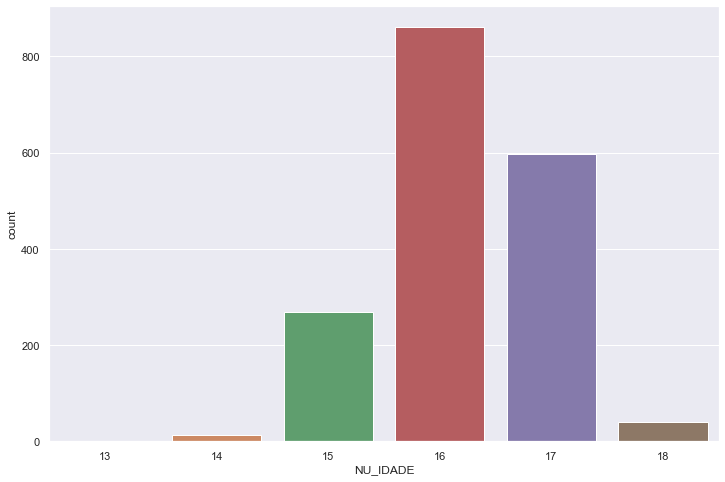

In [22]:
sns.countplot(x='NU_IDADE', data=train_data[train_data['IN_TREINEIRO']==1]);

Legal, então não temos treineiros na nossa base de treino com mais de 18 anos.

Vamos agora verificar dos que tem até 18 anos como que está a distribuição de quem foi treineiro ou não.

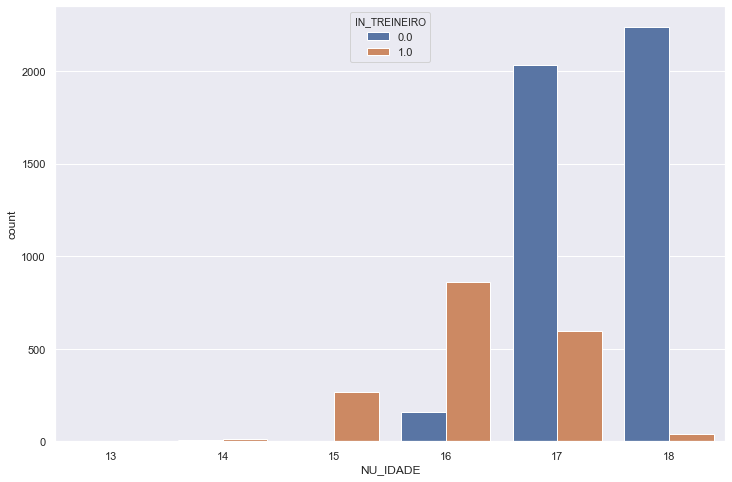

In [23]:
sns.countplot(x='NU_IDADE', hue='IN_TREINEIRO', data=train_data[train_data['NU_IDADE']<=18]);

Beleza. Vamos criar uma categoria para facilitar nosso algoritmo separando aqueles com até 15 anos, outra pra quem tem 16, outra para 17, outra para 18 e outra para o resto.

In [24]:
data['TP_IDADE_AGRUPADA'] = pd.cut(data['NU_IDADE'], bins=[0, 16, 17, 18, 19, 100], labels=range(5)).ravel()
# as colunas de idade e indicando se é idoso não fazem mais sentido
data.drop(columns=['NU_IDADE', 'IN_IDOSO'], inplace=True)
# atualizando nossa train_data para as próximas análises
train_data = data.xs('train')

#### Simplificando `TP_ANO_CONCLUIU`

Essa feature parece promissora, pois está relacionada a quando a pessoa terminou o ensino médio.

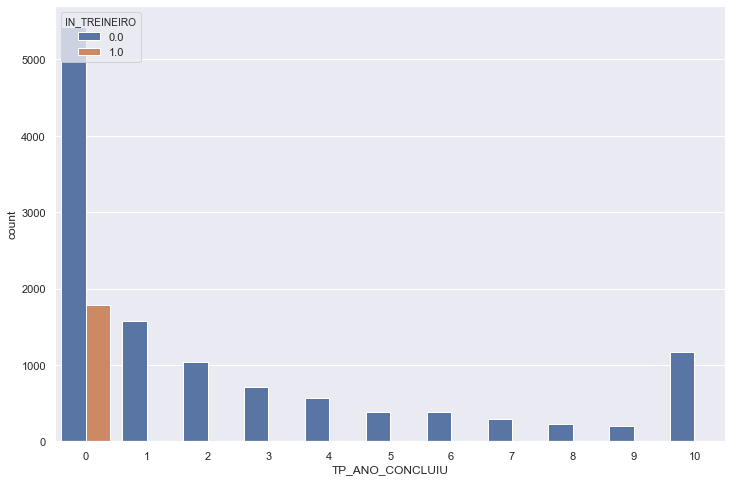

In [25]:
sns.countplot(x='TP_ANO_CONCLUIU', hue='IN_TREINEIRO', data=train_data);

Opa! Parece óbvio, mas os treineiros ficaram relacionados àqueles que ainda não concluíram o ensino médio.

Vamos fazer um tira-teima.

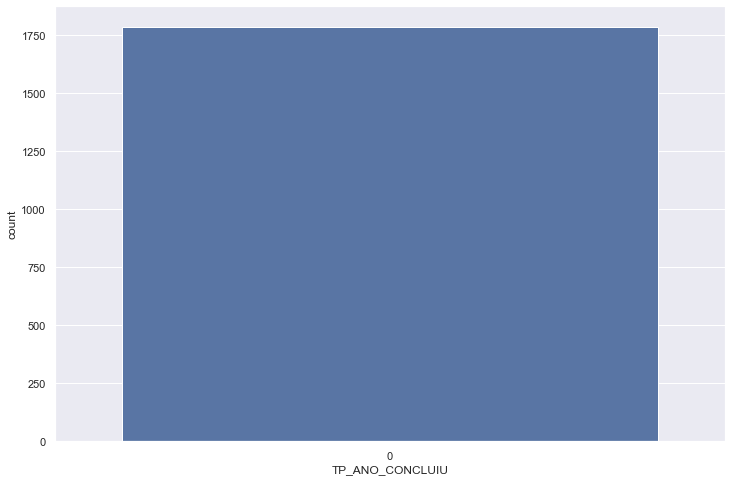

In [26]:
sns.countplot(x='TP_ANO_CONCLUIU', data=train_data[train_data['IN_TREINEIRO']==1]);

Então, vamos deixar nosso `0` em paz e todo o resto como `1`.

In [27]:
data['TP_ANO_CONCLUIU'] = data['TP_ANO_CONCLUIU'].astype('bool').astype('int')
# atualizando train_data para nossas próximas análises
train_data = data.xs('train')

### Visualizações

Vamos agora ver de forma geral como estão distribuídos nossos dados em features categóricas e numéricas.

#### Features categóricas

In [28]:
def gen_countplots(data, features, target, cols=1, title=''):
    """
    Apresenta gráficos de frequência de valores para cada feature indicada
    
    :param train: dataframe de treino
    :param test: dataframe de teste
    :param features: features que queremos apresentar
    :param cols: número máximo de colunas da grade
    :param title: título da figura
    """
    rows = math.ceil(len(features) / cols)
    figwidth  = 5 * cols
    figheight = 4 * rows
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(figwidth, figheight))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    ax = ax.ravel()
    
    for i, feature in enumerate(features):
        sns.countplot(x=data[feature], hue=data[target], ax=ax[i])
        
    fig.suptitle(title, size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.8)
    plt.show()

In [29]:
categorical_features = [
    'CO_UF_RESIDENCIA',
    'IN_GESTANTE',
    'IN_PCD',
    'IN_SABATISTA',
    'Q001',
    'Q002',
    'Q006',
    'Q024',
    'Q025',
    'Q026',
    'Q047',
    'TP_ANO_CONCLUIU',
    'TP_COR_RACA',
    'TP_ESCOLA',
    'TP_LINGUA',
    'TP_PRESENCA_CH',
    'TP_PRESENCA_CN',
    'TP_PRESENCA_LC',
    'TP_SEXO',
    'TP_STATUS_REDACAO',
    'TP_ST_CONCLUSAO',
    'TP_IDADE_AGRUPADA', 
    'IN_ESTRANGEIRO'
]

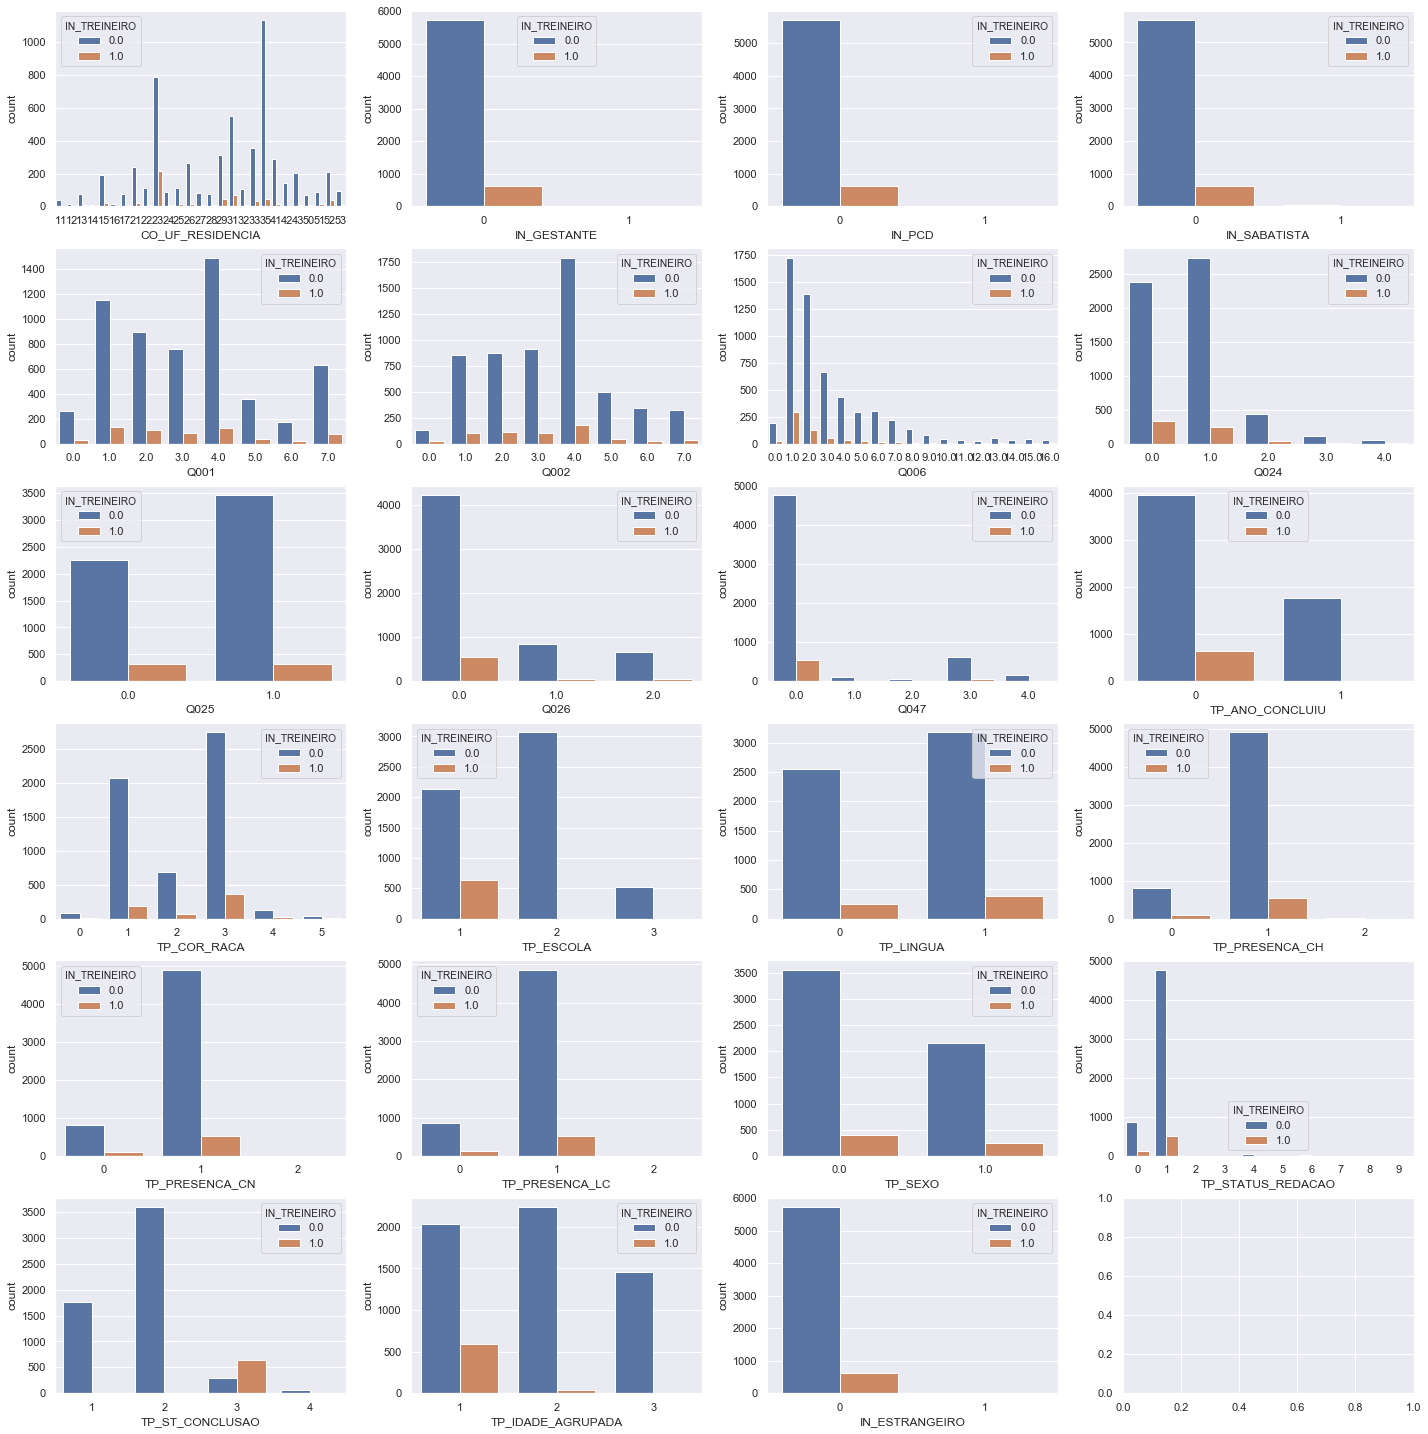

In [30]:
gen_countplots(train_data[train_data['TP_IDADE_AGRUPADA'].between(1, 3)], categorical_features, target_col, cols=4)

Olhando assim, já conseguimos perceber que tem features promissoras, como `TP_ST_CONCLUSAO` e `TP_ESCOLA`. Vamos rodar algumas estatísticas para comprovar o que estamos vendo nos gráficos.

In [32]:
def run_categorical_tests(data, categorical_features, target):
    alpha = 0.05
    print(f'Comparando hipóteses com significância de {alpha:.2f}')
    print('.. H0: As amostras são independentes')
    print('.. H1: As amostras são dependentes')
    print()
    
    for feature in categorical_features:
        contingency_table = data.pivot_table(index=target, columns=feature, aggfunc='size', fill_value=0)
        stat, p, dof, expected = sct.chi2_contingency(contingency_table.values)
        
        msg_result = 'dependente (rejeitar H0)' if p <= alpha else 'independente (falha ao rejeitar H0)'
        print(f'> {feature}: {msg_result} (p-value={p:.3f})')

In [33]:
run_categorical_tests(train_data[train_data['TP_IDADE_AGRUPADA'].between(1, 3)], 
                      categorical_features, 
                      target_col)

Comparando hipóteses com significância de 0.05
.. H0: As amostras são independentes
.. H1: As amostras são dependentes

> CO_UF_RESIDENCIA: dependente (rejeitar H0) (p-value=0.000)
> IN_GESTANTE: independente (falha ao rejeitar H0) (p-value=0.703)
> IN_PCD: independente (falha ao rejeitar H0) (p-value=0.658)
> IN_SABATISTA: independente (falha ao rejeitar H0) (p-value=0.841)
> Q001: independente (falha ao rejeitar H0) (p-value=0.137)
> Q002: independente (falha ao rejeitar H0) (p-value=0.180)
> Q006: dependente (rejeitar H0) (p-value=0.000)
> Q024: dependente (rejeitar H0) (p-value=0.000)
> Q025: dependente (rejeitar H0) (p-value=0.000)
> Q026: dependente (rejeitar H0) (p-value=0.000)
> Q047: independente (falha ao rejeitar H0) (p-value=0.335)
> TP_ANO_CONCLUIU: dependente (rejeitar H0) (p-value=0.000)
> TP_COR_RACA: dependente (rejeitar H0) (p-value=0.000)
> TP_ESCOLA: dependente (rejeitar H0) (p-value=0.000)
> TP_LINGUA: dependente (rejeitar H0) (p-value=0.016)
> TP_PRESENCA_CH: inde

Bem legal! Independente do resultado, vou deixar as features categóricas intactas.

#### Features numéricas

In [34]:
def gen_distplots(train, test, features, cols=1, title=''):
    """
    Apresenta gráficos de distribuição de valores de treino e teste sobrepostos para cada feature indicada
    
    :param train: dataframe de treino
    :param test: dataframe de teste
    :param features: features que queremos apresentar
    :param cols: número máximo de colunas da grade
    :param title: título da figura
    """
    rows = math.ceil(len(features) / cols)
    figwidth  = 5 * cols
    figheight = 4 * rows
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(figwidth, figheight))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    ax = ax.ravel()
    
    for i, feature in enumerate(features):
        sns.distplot(train[feature].dropna(), color='blue', ax=ax[i])
        sns.distplot(test[feature].dropna(), color='red', ax=ax[i])
        
    fig.suptitle(title, size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.8)
    plt.show()

In [35]:
numeric_features = [
    'NU_NOTA_CH',
    'NU_NOTA_CN',
    'NU_NOTA_COMP1',
    'NU_NOTA_COMP2',
    'NU_NOTA_COMP3',
    'NU_NOTA_COMP4',
    'NU_NOTA_COMP5',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO',
]

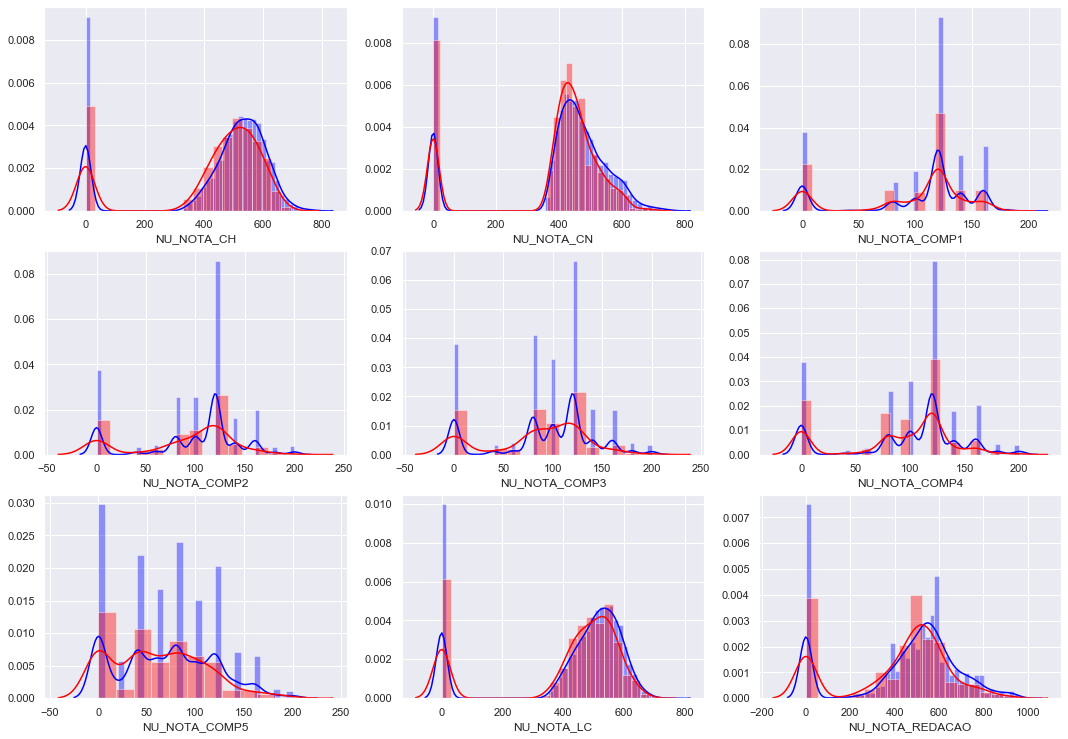

In [36]:
gen_distplots(train_data[train_data['TP_IDADE_AGRUPADA'].between(1, 3) & (train_data['IN_TREINEIRO']==0)], 
              train_data[train_data['TP_IDADE_AGRUPADA'].between(1, 3) & (train_data['IN_TREINEIRO']==1)], 
              features=numeric_features, 
              cols=3)

Legal. Há algum tipo de variação sim das notas. Vamos executar alguns testes estatísticos para comprovar o que estamos vendo.

In [37]:
def run_numeric_tests(data, numeric_features, target):
    alpha = 0.05
    print(f'Comparando hipóteses com significância de {alpha:.2f}')
    print('.. H0: As amostras possuem distribuições semelhantes')
    print('.. H1: As amostras não possuem distribuições semelhantes')
    print()
    
    samples = [subdf for _, subdf in data.groupby(target)]
    for feature in numeric_features:
        stat, p = sct.kruskal(*([df[feature] for df in samples]))
        msg_result = 'diferentes (rejeitar H0)' if p <= alpha else 'semelhantes (falha ao rejeitar H0)'
        print(f'> {feature}: {msg_result} (p-value={p:.3f})')

In [38]:
run_numeric_tests(train_data[train_data['TP_IDADE_AGRUPADA'].between(1, 3)], 
                  numeric_features, 
                  target_col)

Comparando hipóteses com significância de 0.05
.. H0: As amostras possuem distribuições semelhantes
.. H1: As amostras não possuem distribuições semelhantes

> NU_NOTA_CH: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_CN: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_COMP1: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_COMP2: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_COMP3: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_COMP4: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_COMP5: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_LC: diferentes (rejeitar H0) (p-value=0.000)
> NU_NOTA_REDACAO: diferentes (rejeitar H0) (p-value=0.000)


## Definindo `X` e `y`

In [39]:
train_data, test_data = data.xs('train'), data.xs('test')

In [40]:
features = categorical_features + numeric_features

X = train_data[features]
y = train_data[target_col]

X_test = test_data[features]

Vamos usar toda a base de treino. Não vou complicar dessa vez criando validação cruzada, etc.

In [44]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])
rfc.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CO_UF_RESIDENCIA',
                                                   'IN_GESTANTE', 'IN_PCD',
                                                   'IN_SABATISTA', 'Q001',
                                                   'Q002', 'Q006', 'Q024',
                                                   'Q025', 'Q026', 'Q047',
                                                   'TP_ANO_CONCLUIU',
                                                   'TP_COR_RACA', 'TP_ESCOLA',
                                                   'TP_LINGUA',
                                                   'TP_PRESENCA_CH',
         

In [45]:
preds = rfc.predict(X_test)

## Exportando resultados

In [46]:
output_data = df_test.iloc[:, [0]]
output_data[target_col] = preds
print(output_data.head())

                               NU_INSCRICAO  IN_TREINEIRO
0  ba0cc30ba34e7a46764c09dfc38ed83d15828897           0.0
1  177f281c68fa032aedbd842a745da68490926cd2           0.0
2  6cf0d8b97597d7625cdedc7bdb6c0f052286c334           1.0
3  5c356d810fa57671402502cd0933e5601a2ebf1e           0.0
4  df47c07bd881c2db3f38c6048bf77c132ad0ceb3           0.0


In [47]:
output_data.to_csv('answer.csv', index=False)

Score no codenation: 99.759300